Example 6.5: Windy Gridworld - SARSA

Parameters:
  Episodes: 170
  Alpha (step size): 0.5
  Gamma (discount): 1.0
  Epsilon (exploration): 0.1

Running SARSA...
Generating plot...


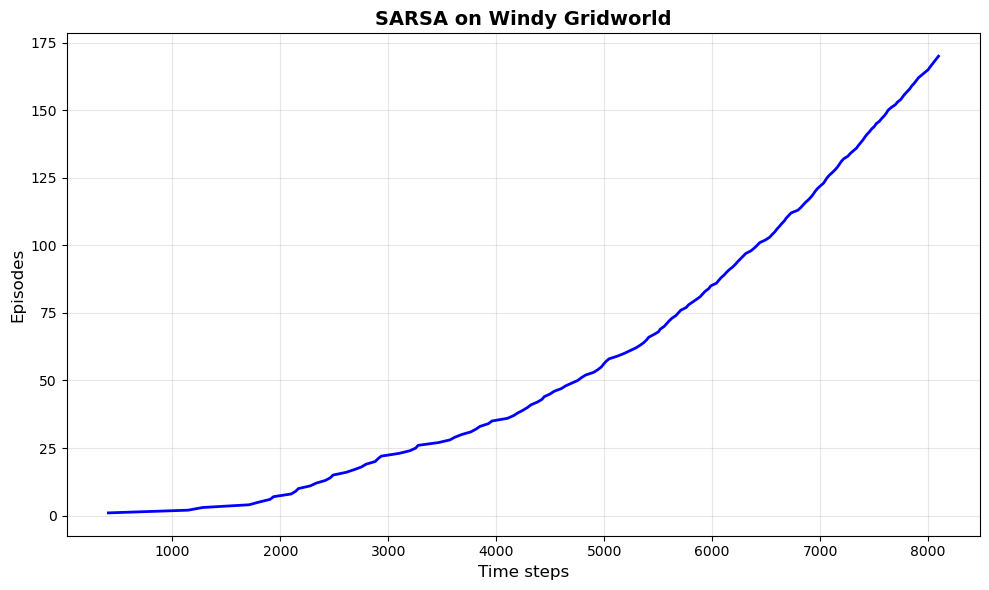

In [ ]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Example 6.5
# Implementation of SARSA (on-policy TD control) for the Windy Gridworld problem
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


class WindyGridworld:
    """    
	standard gridworld with start and goal positions, but with a crosswind
    running upward through the middle of the grid. actions are standard
    (up, down, right, left) but in some columns the resulting next state
    is shifted upward by the wind.
    """
    
    def __init__(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        # grid dimensions
        self.grid_height = 7
        self.grid_width = 10
        
        # start and goal positions (row, col)
        self.start_pos = (3, 0)  # start at middle left
        self.goal_pos = (3, 7)   # goal at middle right
        
        # wind strength for each column (pushes upward)
        # columns: 0  1  2  3  4  5  6  7  8  9
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        
        # actions: up, down, right, left
        self.actions = ['up', 'down', 'right', 'left']
        self.action_effects = {
            'up': (-1, 0),
            'down': (1, 0),
            'right': (0, 1),
            'left': (0, -1)
        }
        
        # current state
        self.current_state = None
        
    def reset(self):
        """reset environment to start state and return it"""
        self.current_state = self.start_pos
        return self.current_state
    
    def step(self, action):
        """
        take action and return next state, reward, done flag
        note:reward is -1 for each step, regardless of action
        """
        row, col = self.current_state
        
        # apply action
        d_row, d_col = self.action_effects[action]
        new_row = row + d_row
        new_col = col + d_col
        
        # apply wind (pushes upward, so subtract from row)
        wind_strength = self.wind[col]
        new_row -= wind_strength
        
        # keep within bounds
        new_row = max(0, min(self.grid_height - 1, new_row))
        new_col = max(0, min(self.grid_width - 1, new_col))
        
        # update state
        self.current_state = (new_row, new_col)
        
        # check if goal reached
        done = (self.current_state == self.goal_pos)
        
        # reward is -1 until goal is reached
        reward = -1
        
        return self.current_state, reward, done
    
    def is_terminal(self, state):
        """check if state is terminal (goal state)"""
        return state == self.goal_pos


def epsilon_greedy_policy(Q, state, epsilon, actions):
    """    
    epsilon-greedy: 
    - with prob epsilon: choose random action (exploration)
    - with prob 1-epsilon: choose action with highest Q value (exploitation)
    """
    if np.random.random() < epsilon:
        # explore: random action
        return np.random.choice(actions)
    else:
        # exploit: best action
        # get Q values for all actions from this state
        q_values = [Q[(state, action)] for action in actions]
        max_q = max(q_values)
        
        # handle ties by randomly choosing among
        best_actions = [actions[i] for i in range(len(actions)) 
                       if q_values[i] == max_q]
        return np.random.choice(best_actions)


def sarsa(env, num_episodes, alpha=0.5, gamma=1.0, epsilon=0.1):
    """    
    from textbook page 130, the SARSA algorithm:
    
    initialize Q(s,a) to 0 for all s, a
    loop for each episode:
        initialize S (reset environment)
        choose A from S using policy derived from Q (e.g., epsilon-greedy)
        loop for each step of episode:
            take action A, observe R, S'
            choose A' from S' using policy derived from Q
            Q(S,A) <- Q(S,A) + alpha[R + gamma*Q(S',A') - Q(S,A)]
            S <- S'; A <- A'
        until S is terminal
    
	notes from textbook notes:
    - SARSA is ON-POLICY: it learns from the policy it's currently following
    - the update uses the ACTUAL next action A' that the policy will take
    """
    # initialize Q(s,a) to 0 for all state-action pairs
    Q = defaultdict(float)
    
    # track episode lengths for plotting
    episode_lengths = []
    time_steps = []
    total_steps = 0
    
    # run episodes
    for episode in range(num_episodes):
        # initialize S
        state = env.reset()
        
        # choose A from S using epsilon-greedy policy derived from Q
        action = epsilon_greedy_policy(Q, state, epsilon, env.actions)
        
        steps_in_episode = 0
        
        # loop for each step of episode
        while True:
            # take action A, observe R, S'
            next_state, reward, done = env.step(action)
            
            steps_in_episode += 1
            total_steps += 1
            
            if done:
                # terminal state: update Q and end episode
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
                break
            
            # choose A' from S' using epsilon-greedy policy derived from Q
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.actions)
            
            # SARSA update rule:
            # Q(S,A) <- Q(S,A) + alpha[R + gamma*Q(S',A') - Q(S,A)]
            td_target = reward + gamma * Q[(next_state, next_action)]
            td_error = td_target - Q[(state, action)]
            Q[(state, action)] += alpha * td_error
            
            # S <- S'; A <- A'
            state = next_state
            action = next_action
        
        episode_lengths.append(steps_in_episode)
        time_steps.append(total_steps)
    
    return Q, episode_lengths, time_steps


def plot_results(time_steps, episode_numbers):
    """
    reproduce the plot from example 6.5
    """
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, episode_numbers, linewidth=2, color='blue')
    plt.xlabel('Time steps', fontsize=12)
    plt.ylabel('Episodes', fontsize=12)
    plt.title('SARSA on Windy Gridworld', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('windy_gridworld_sarsa.png', dpi=300, bbox_inches='tight')
    plt.show()


def get_greedy_path(env, Q):
    """
    this shows what the agent learned: starting from the initial state,
    always choose the action with the highest Q value (greedy, no exploration).
    """
    state = env.reset()
    path = [state]
    steps = 0
    max_steps = 100  # prevent infinite loops
    
    while not env.is_terminal(state) and steps < max_steps:
        # choose greedy action (epsilon=0)
        action = epsilon_greedy_policy(Q, state, epsilon=0.0, actions=env.actions)
        state, _, _ = env.step(action)
        path.append(state)
        steps += 1
    
    return path

if __name__ == "__main__":
    print("=" * 60)
    print("Example 6.5: Windy Gridworld - SARSA")
    print("=" * 60)
    print()
    
    # parameters from the book
    num_episodes = 170
    alpha = 0.5
    gamma = 1.0  # undiscounted episodes
    epsilon = 0.1
    
    # create environment
    env = WindyGridworld(seed=42)
    
    #print("Running SARSA...")
    Q, episode_lengths, time_steps = sarsa(env, num_episodes, alpha, gamma, epsilon)
    
    # convert to episode numbers for plotting
    episode_numbers = list(range(1, len(time_steps) + 1))
    
    #print("Generating plot...")
    plot_results(time_steps, episode_numbers)   